### **Part 3**
**Tasks**
* explore proper visual stimuli
  * spontaneous state
  * (done) evoked state: drifting
* Communication subspaces across different areas
  * (done) correlation
  * (done) dimensionality
    * intra_areas
    * inter_areas
* Information flow across subspaces
  * (done) direction: population correlation as the function of the time delay between areas ($t_2$-$t_1$)
  * intensity (correlation intensity)
* Hierarchy of information flow  across these subspaces
  * direction
    * (done) inter_areas cca_delay
    * *intra_areas cca_delay (layer_dependent)*
    * (done) feedfward and feedback
    * *input/output dimensions*
  * function validation
* Relation between different information flow channels
  * *subspace & layer_dependent*
  * shared dimensionility
  * *generalize canonical dimension across subspaces*
  * subspaces angle
  * CCA across subspaces
  * predictive coding
* (to do) State dependent geometrical properties of these channels
* (to do) Dynamical system across areas modeled by multi-region RNN network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_id = 799864342
session = cache.get_session_data(session_id)

drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1590.310709,2,drifting_gratings,1592.312419,4,2.00171,246
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3800,0.8,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1596.315739,2,drifting_gratings,1598.317439,15,2.00170,248
3801,0.8,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1599.318261,2,drifting_gratings,1601.319921,1,2.00166,249
3802,null,null,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",null,1602.320789,2,drifting_gratings,1604.322439,null,2.00165,250


In [3]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix _summary_

    _extended_summary_

    Arguments:
        area -- _description_
        stim_table -- _description_

    Keyword Arguments:
        bin -- _description_ (default: {0.1})
        period -- _description_ (default: {2})

    Returns:
        _description_
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes

def corr_area_pairs(X_a, X_b, n_components = 3):
    """corr_area_pairs _summary_

    _extended_summary_

    Arguments:
        X_a -- _description_
        X_b -- _description_
    """

    cca = CCA(n_components, max_iter=1000)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) 

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b), (z_a, z_b)

def cca_delay_areas(area_1, area_2, trial_len=2000, window_len=200, step_len=40, bin_len=50, max_delay=100):

    # correlation by delay when time bin = 1ms, with window 200ms, window slide advanced 40ms

    raster_bin = 1  # bin time, 1ms

    spike_raster_1 = spike_matrix(area=area_1, stim_table=drift_stim_table, bin=raster_bin/1000)
    spike_raster_2 = spike_matrix(area=area_2, stim_table=drift_stim_table, bin=raster_bin/1000)

    step_points = np.arange(0, trial_len-window_len, step_len)

    corr_matrix_delay = np.zeros((len(step_points), 2*max_delay))

    for step_id, step in enumerate(step_points):
        t_1 = step
        window_1 = np.arange(t_1, t_1+window_len)
        spike_counts_1 = spike_counts_bins(spike_raster_1[:, window_1, :], bin_len)
        spike_counts_1 = spike_counts_1.reshape([spike_counts_1.shape[0]*spike_counts_1.shape[1],
                                                spike_counts_1.shape[2]])

        slide_points = range(max(t_1-max_delay, 0), min(t_1+max_delay, trial_len-window_len))

        for slide_id, slide in enumerate(slide_points):
            t_2 = slide
            window_2 = np.arange(t_2, t_2+window_len)
            spike_counts_2 = spike_counts_bins(spike_raster_2[:, window_2, :], bin_len)
            spike_counts_2 = spike_counts_2.reshape([spike_counts_2.shape[0]*spike_counts_2.shape[1],
                                                spike_counts_2.shape[2]])

            corr, w, z = corr_area_pairs(spike_counts_1, spike_counts_2)
            corr_matrix_delay[step_id, t_2-t_1+max_delay] = corr[0]

    # print(corr_matrix_delay.shape)
    # mask no correlation value
    corr_matrix_delay = np.ma.masked_where(corr_matrix_delay == 0, corr_matrix_delay)

    return corr_matrix_delay

def get_feedforward_ratio(corr_matrix_delay, step=5):

    max_delay = int(corr_matrix_delay.shape[1]/2)
        
    negative_delay_area = np.sum(corr_matrix_delay[step, :max_delay])
    positive_delay_area = np.sum(corr_matrix_delay[step, max_delay:])

    feedforward_ratio = (positive_delay_area-negative_delay_area)/(positive_delay_area+negative_delay_area)

    return feedforward_ratio

In [4]:
def plot_corr_delay_matrix(corr_matrix_delay, area_1, area_2):
    
    max_delay = int(corr_matrix_delay.shape[1]/2)

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(corr_matrix_delay)

    ax.set_xticks(range(0, corr_matrix_delay.shape[1], 20))
    ax.set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))
    # ax.set_yticks(range(len(areas))+np.array([0.5]))
    # ax.set_yticklabels(areas)
    ax.set_xlabel('Delay, ms')
    ax.set_ylabel('step_num, *40ms')
    ax.set_title(f'correlation_delay between {area_1} & {area_2}')

    f.colorbar(im)

    plt.show

    return

def plot_corr_delay(corr_matrix_delay, area_1, area_2):

    max_delay = int(corr_matrix_delay.shape[1]/2)
    step_list = [5, 10, 20, 30, 39]

    for i, step in enumerate(step_list):

        plt.figure()
        plt.plot(range(-max_delay, max_delay), corr_matrix_delay[step, :])
        # plt.vlines(np.argmax(corr_matrix_delay[step, :])-max_delay, 0.4, 1, colors = "g", linestyles = "dashed")
        # plt.vlines(0, 0.4, 1, colors = "r", linestyles = "dashed")
        plt.title(f'correlation_delay in step {step} between {area_1} & {area_2}')
        plt.xlabel('delay')
        plt.ylabel('corrlelation')
        plt.show

    return

def plot_corr_step(corr_matrix_delay, area_1, area_2):

    max_delay = int(corr_matrix_delay.shape[1]/2)
    delay_list = [-80, -40, 0, 40, 80]

    for delay in delay_list:
        plt.figure()
        plt.plot(range(corr_matrix_delay.shape[0]), corr_matrix_delay[:, delay+max_delay])
        plt.title(f'correlation_delay in delay {delay} between {area_1} & {area_2}')
        plt.xlabel('step, *40ms')
        plt.ylabel('corrlelation')
        # plt.ylim(0.6, 0.9)
        plt.show

    return

def plot_feedforward_ratio(corr_matrix_delay, area_1, area_2):

    step_list = [5, 10, 20, 30, 39]
    feedforward_ratio = np.zeros(len(step_list))

    for i, step in enumerate(step_list):

        feedforward_ratio[i] = get_feedforward_ratio(corr_matrix_delay, step=step)
    
    plt.figure()
    plt.plot(range(len(step_list)), feedforward_ratio)
    plt.xticks(ticks=np.arange(len(step_list))+[0.5], labels=step_list)
    plt.title(f'feedforward_ratio between {area_1} & {area_2}')
    plt.xlabel('step')
    plt.ylabel('feedforward_ratio')
    plt.show

    return 

### Task5 Hierarchy of information flow
* input/output dimensions
* across areas & across sessions, save these large data which waste to much time

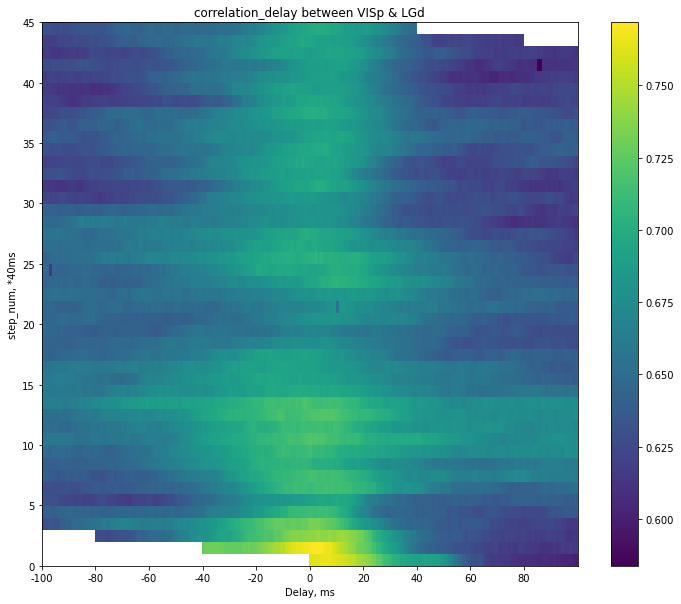

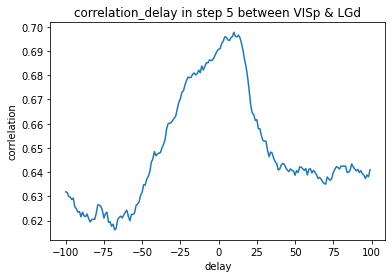

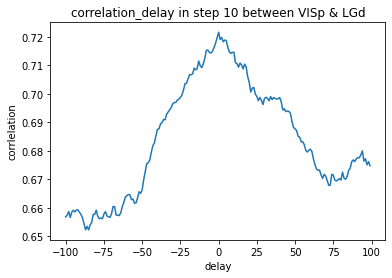

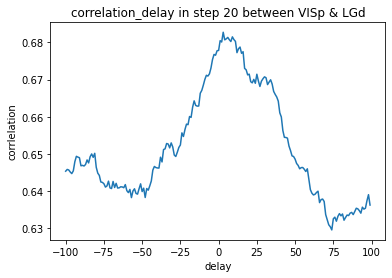

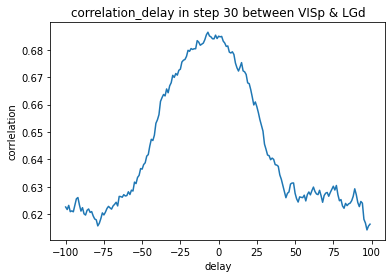

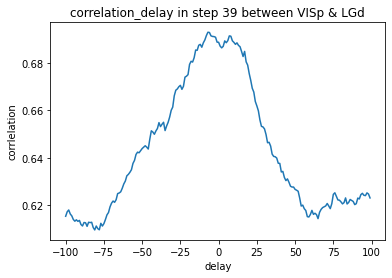

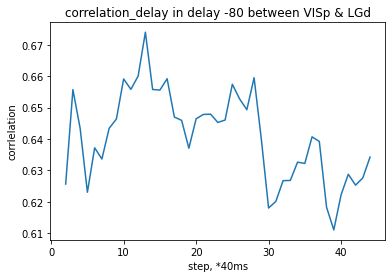

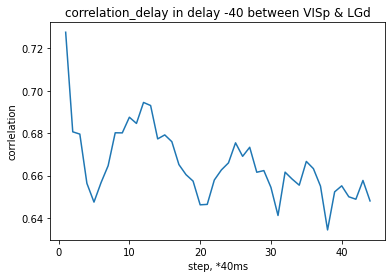

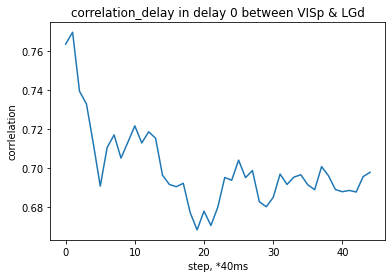

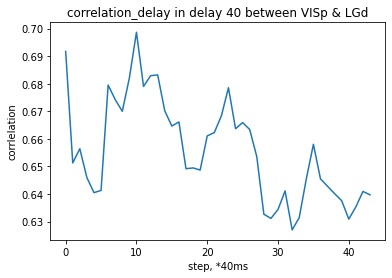

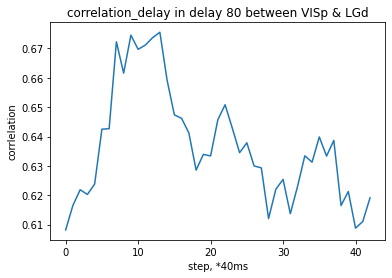

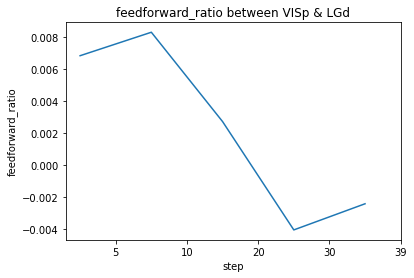

In [5]:
area_1 = 'VISp'
area_2 = 'LGd'

corr_matrix_delay = cca_delay_areas(area_1, area_2)

plot_corr_delay_matrix(corr_matrix_delay, area_1, area_2)
plot_corr_delay(corr_matrix_delay, area_1, area_2)
plot_corr_step(corr_matrix_delay, area_1, area_2)
plot_feedforward_ratio(corr_matrix_delay, area_1, area_2)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations 

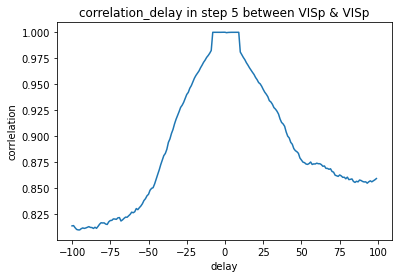

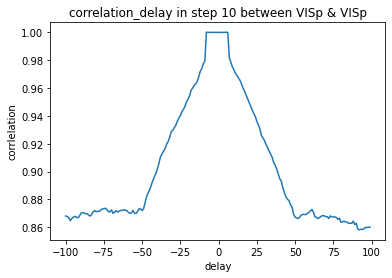

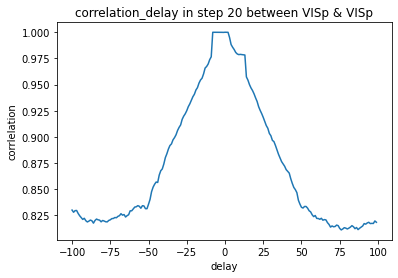

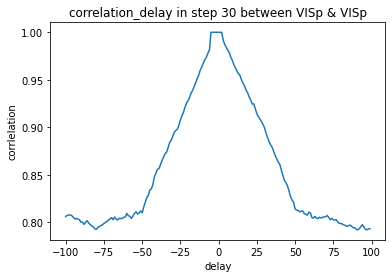

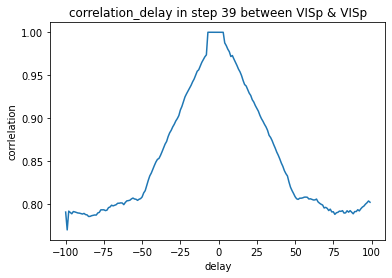

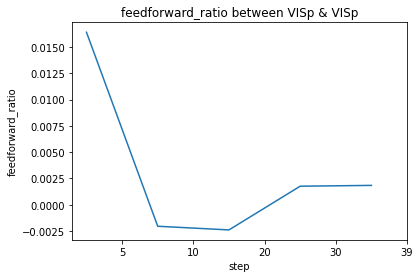

In [33]:
area_1 = 'VISp'
area_2 = 'VISp'

corr_matrix_delay = cca_delay_areas(area_1, area_2)
plot_corr_delay(corr_matrix_delay, area_1, area_2)
plot_feedforward_ratio(corr_matrix_delay, area_1, area_2)

* ff_ratio mean ?

In [40]:
def feedforward_ratio_areas(areas):

    feedforward_ratio_matrix = np.zeros((len(areas), len(areas)))

    for i, area_1 in enumerate(areas):
        for j, area_2 in enumerate(areas):
            corr_matrix_delay = cca_delay_areas(area_1, area_2)
            feedforward_ratio_matrix[i, j] = get_feedforward_ratio(corr_matrix_delay, step=5)

    return feedforward_ratio_matrix

def get_ff_fd_ratio(feedforward_ratio_array):

    # print(feedforward_ratio_array)
    feedforward_num = len(np.where(feedforward_ratio_array>0)[0])
    feedback_num = len(np.where(feedforward_ratio_array<0)[0])
    # print('feedforward_num', feedforward_num)
    # print('feedback_num', feedback_num)

    ff_fd_ratio = (feedforward_num-feedback_num)/(feedforward_num+feedback_num)

    return ff_fd_ratio


def plot_ff_ratio_matrix(feedforward_ratio_matrix, areas):

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(feedforward_ratio_matrix)

    ax.set_xticks(range(len(areas))+np.array([0.5]))
    ax.set_xticklabels(areas)
    ax.set_yticks(range(len(areas))+np.array([0.5]))
    ax.set_yticklabels(areas)
    # ax.set_xlabel('Delay, ms')
    # ax.set_ylabel('step_num, *40ms')
    ax.set_title(f'feedforward_ratio_matrix')

    f.colorbar(im)
    plt.show()

    return

def plot_ff_ratio_changing(feedforward_ratio_matrix, areas):

    f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(24, 28), sharex=True)

    for i, area in enumerate(areas):
        
        axes[i].plot(np.array(range(len(areas))), feedforward_ratio_matrix[i, :])
        axes[i].hlines(y=0, xmin=0, xmax=1, colors = "r", linestyles = "dashed")
        axes[i].bar(np.array(range(len(areas))), feedforward_ratio_matrix[i, :], width=0.6, tick_label=areas, fc='c')
        axes[i].set_ylabel(f'{area}')

    f.suptitle('ff_ratio across areas')
    plt.tight_layout()
    plt.show()

    return

def plot_ff_fd_ratio(feedforward_ratio_matrix, areas):

    ff_fd_ratio = np.zeros(len(areas))
    for i, area in enumerate(areas):
        ff_fd_ratio[i] = get_ff_fd_ratio(feedforward_ratio_matrix[i, :])
    
    # print(ff_fd_ratio)

    f, ax = plt.subplots(figsize=(24, 10))

    ax.plot(np.array(range(len(areas))), ff_fd_ratio)
    ax.bar(np.array(range(len(areas))), ff_fd_ratio, width=0.6, tick_label=areas, fc='c')
    ax.set_ylabel(f'ff_fd_ratio')
    f.suptitle('ff_ratio across areas')

    plt.show()

    return

In [42]:
areas = ['VISp', 'VISam', 'LGd', 'CA1']

feedforward_ratio_matrix = feedforward_ratio_areas(areas)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations 

[[ 1.63988063e-02  6.82419620e-03]
 [ 1.32908996e-02 -7.15307148e-05]]


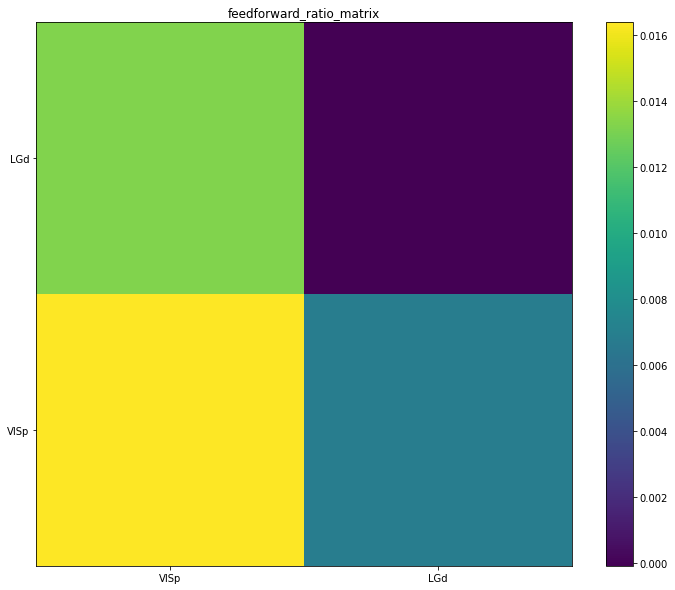

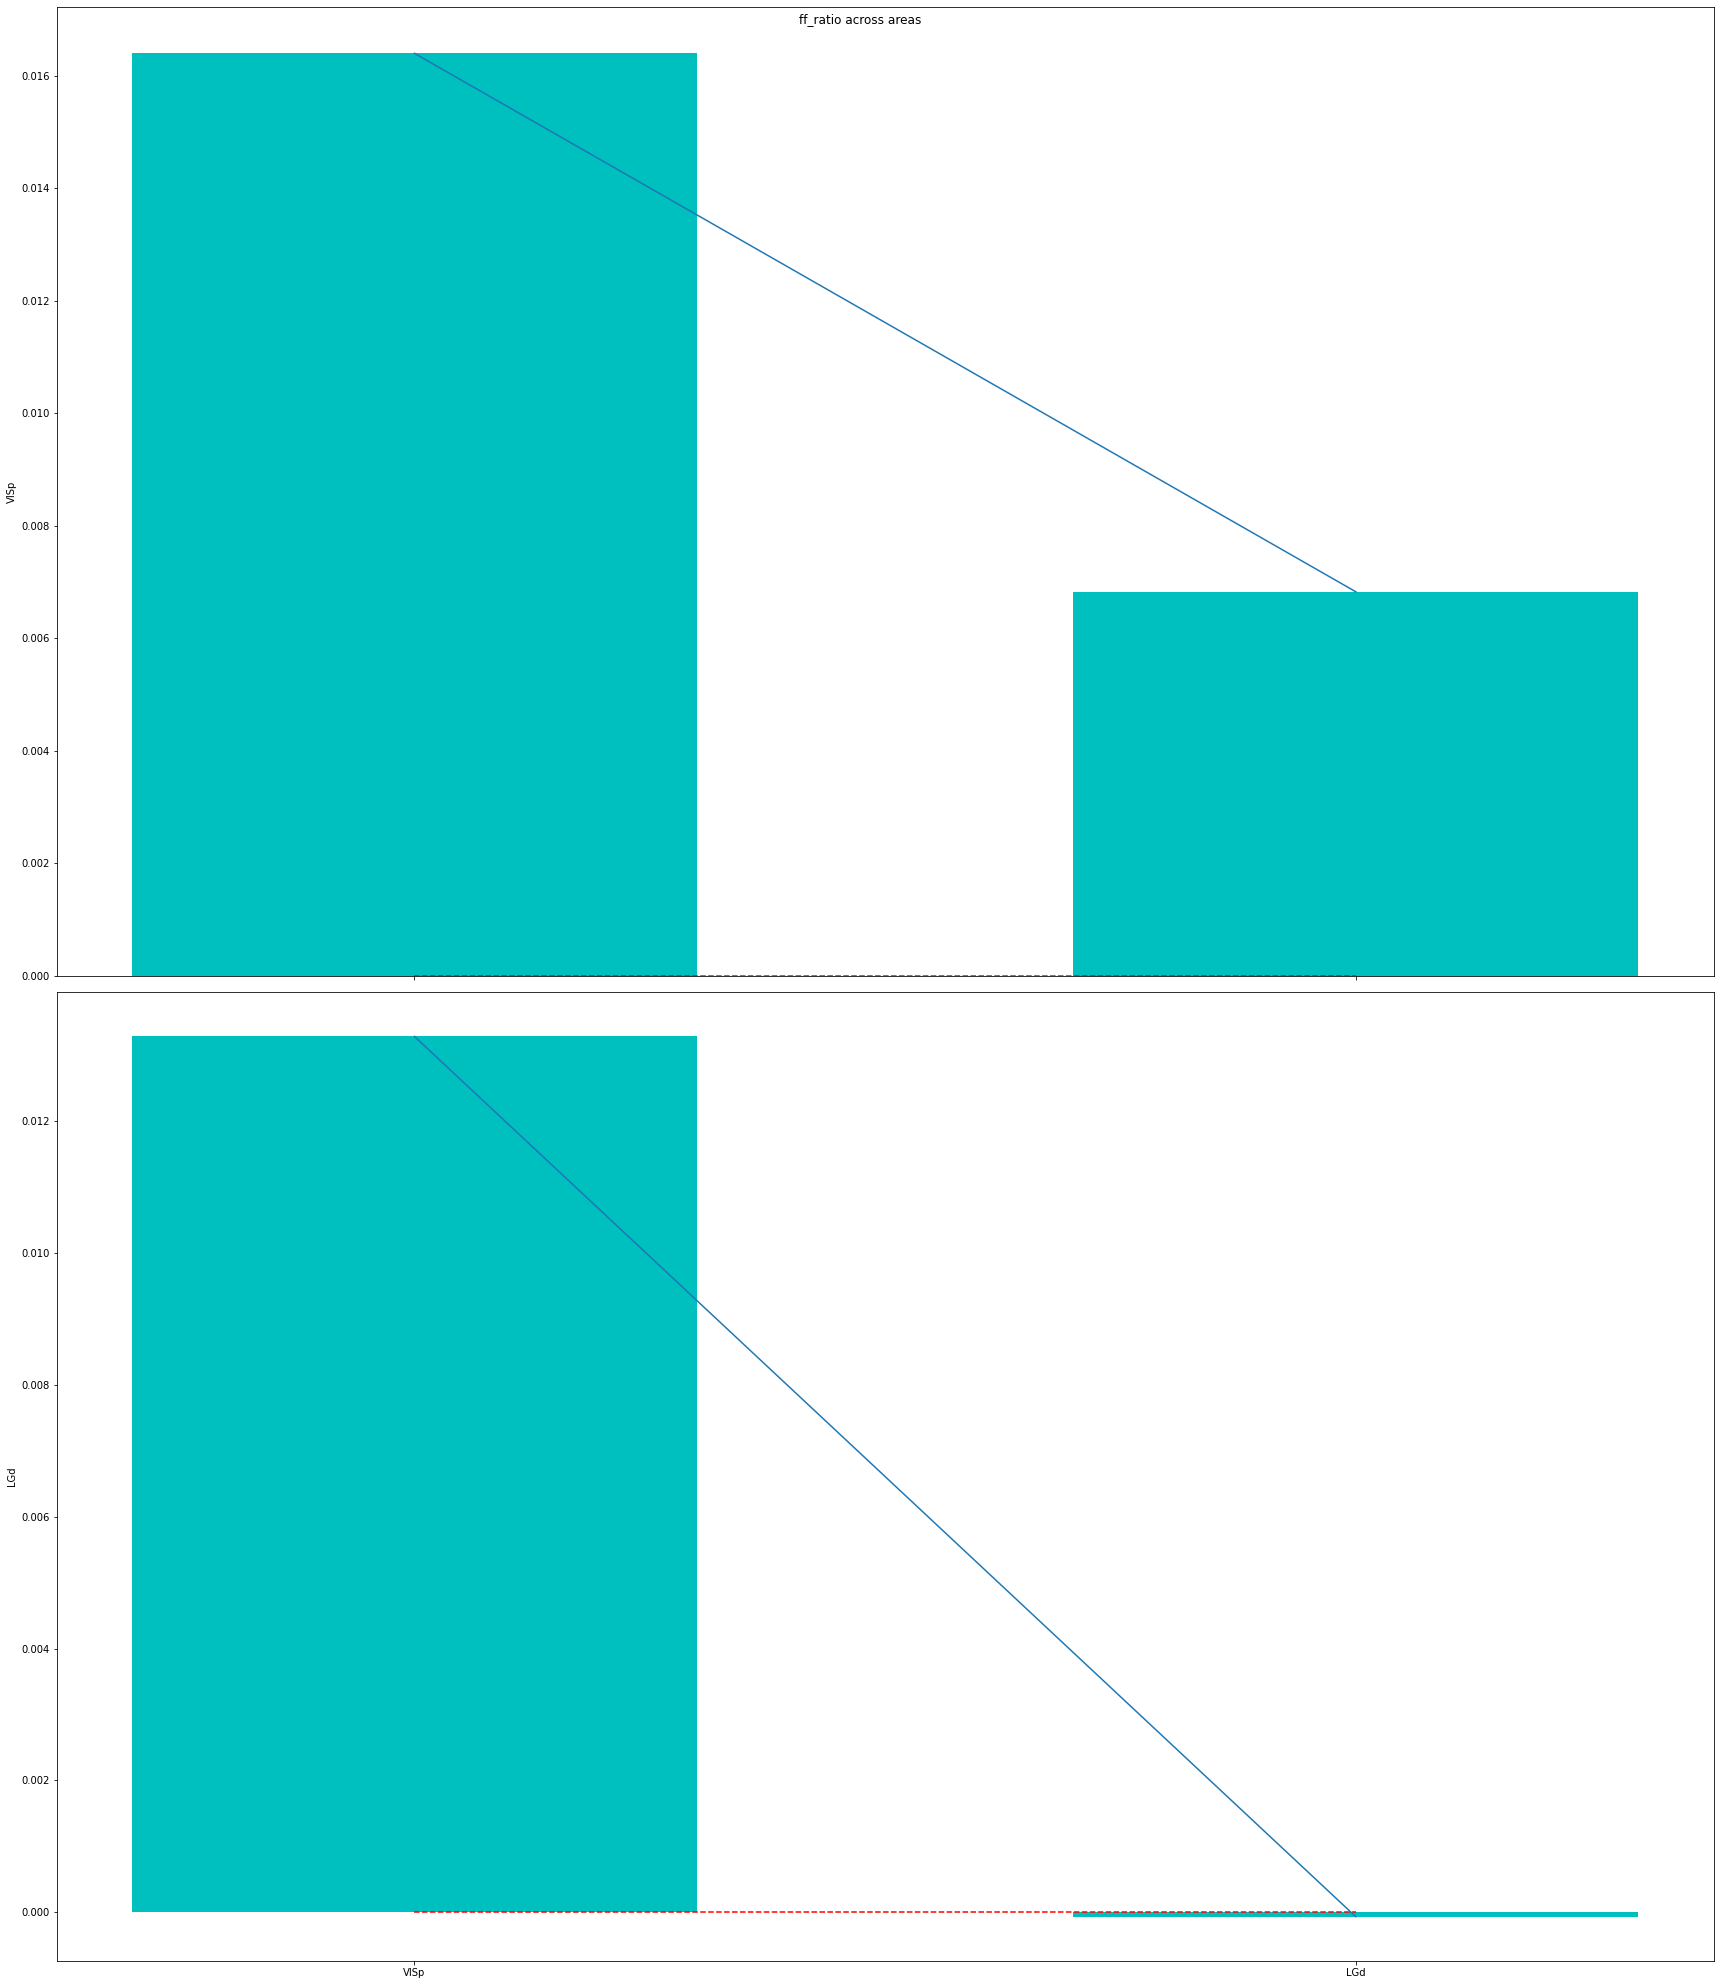

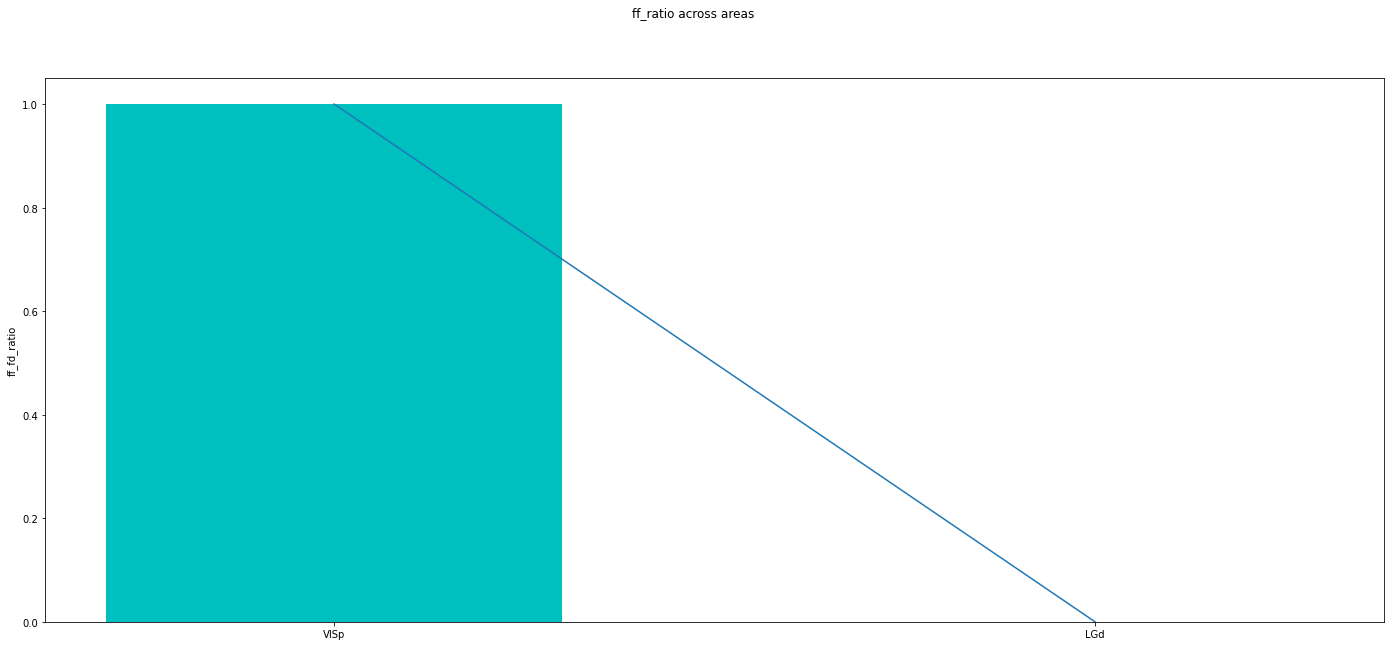

In [41]:
print(feedforward_ratio_matrix)
plot_ff_ratio_matrix(feedforward_ratio_matrix, areas)
plot_ff_ratio_changing(feedforward_ratio_matrix, areas)
plot_ff_fd_ratio(feedforward_ratio_matrix, areas)

### Task6 Relation between subspaces
* generalize canonical dimension across subspaces
* subspaces angle/shared dimensionility

In [ ]:
def get_response_matrix(area, stim_table):

    response_matrix = spike_matrix(area=area, stim_table=stim_table)
    response_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])

    return response_matrix

def get_vectors_angle(v1, v2):

    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    rad = np.arccos(dot_product)
    angle = np.rad2deg(rad)

    return angle


def cca_subspace_dims_angle(area_x, area_y1, area_y2, stim_table):

    res_mat_x = get_response_matrix(area_x, stim_table)
    res_mat_y1 = get_response_matrix(area_y1, stim_table)
    res_mat_y2 = get_response_matrix(area_y2, stim_table)

    _, (w_xy1, _), _ = corr_area_pairs(res_mat_x, res_mat_y1)
    _, (w_xy2, _), _ = corr_area_pairs(res_mat_x, res_mat_y2)

    dims_angle = get_vectors_angle(w_xy1, w_xy2)

    return dims_angle

In [ ]:
area_1 = 'VISp'
area_2 = 'VISam'
area_3 = 'VISrl'

dims_angle = cca_subspace_dims_angle(area_1, area_2, area_3, stim_table=drift_stim_table)

In [ ]:
def cross_val_pCCA(res_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(res_mat):
        train, test = res_mat[train_index], res_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)

        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def inter_dim_pCCA(res_mat_1, res_mat_2):
    
    res_mat = np.concatenate((res_mat_1, res_mat_2), axis = 1)

    N, n_features = res_mat.shape
    _, n_features_1 = res_mat_1.shape
    _, n_features_2 = res_mat_2.shape

    # select proper latent dimensions from [1, n_features-1]
    cv_log_like = np.zeros(n_features-1)
    for i in range(n_features-1):
        latent_dim = i + 1
        cv_log_like[i] = cross_val_pCCA(res_mat, latent_dim)

    latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(res_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    _, sing_vals, _ = np.linalg.svd(load_mat_1.T @ load_mat_2)

    shared_var = np.cumsum(sing_vals)/np.sum(sing_vals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim, (load_mat_1, load_mat_2)

def pCCA_subspaces_angle(area_x, area_y1, area_y2, stim_table):

    res_mat_x = get_response_matrix(area_x, stim_table)
    res_mat_y1 = get_response_matrix(area_y1, stim_table)
    res_mat_y2 = get_response_matrix(area_y2, stim_table)

    _, (load_mat_xy1, _) = inter_dim_pCCA(res_mat_x, res_mat_y1)
    _, (load_mat_xy2, _) = inter_dim_pCCA(res_mat_x, res_mat_y2)

    subspaces_angle = subspace_angles(load_mat_xy1.T, load_mat_xy2.T)

    return subspaces_angle

In [ ]:
area_1 = 'VISp'
area_2 = 'VISam'
area_3 = 'VISrl'

subspaces_angle = pCCA_subspaces_angle(area_1, area_2, area_3, stim_table=drift_stim_table)